# XGBoost bayesian optimization

This notebook contains a documentation on Bayesian optimization applied to the Upgrad Downstream tracking algorithm. 


In [6]:
print ("kernel is alive!")

kernel is alive!


In [13]:
import pandas as pd
import numpy as np
import scipy as sp
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec


import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

#sklearn imports 
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score


# xgboost 
import xgboost as xgb
from xgboost import plot_importance

# bayesian optimization
import GPy
import GPyOpt

from GPyOpt.methods import BayesianOptimization


In [7]:
import sys
!{sys.executable} -m pip install GPyOpt
 

     |████████████████████████████████| 61kB 3.0MB/s eta 0:00:011
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-cp36-none-any.whl size=84684 sha256=b471f424e9ae59e6bc32e510664bf33d788a89e957538f9e970c349e9f484ce2
  Stored in directory: /home/dead7002/.cache/pip/wheels/b2/00/69/cfa967a125cf25e66f644be6193ad6f0edf231147879ad714f
Successfully built GPyOpt


### As a very first step I need to grab training data form the NTpule. 
To obtain this goal I will use **root_numpy**, that allows me to convert root NTuple to pandas.Dataframe

In [4]:
data = pd.read_csv("/data/work/wessex/Wessex/test/Brunel_track_seeds_with_target.csv")
target = data.particle_isDown_noVelo 
features = data.drop(["Unnamed: 0", 
                      "Unnamed: 0_x", # index
                      "Unnamed: 0_y",
                      "eventID",
                      "particle_key",
                      "particle_hasUT",
                      "particle_pid", # this are MC info
                      "particle_hasScifi",
                      "particle_isDown_noVelo",
                      "particle_isDown",
                      "particle_hasVelo",
                      "track_charge",
                      "track_position_z",
                     ], axis=1)
features.head()

,track_phi,track_tx,track_ty,track_nLHCbIDs,track_p,track_chi2,track_position_x,track_position_y,track_chi2PerDoF,track_pt,track_pseudoRapidity,track_position_r,track_position_phi
0,2.849378,-0.343474,0.103326,12.0,2020.072174,6.275086,494.515198,1124.644897,0.896441,682.012956,1.749189,7599.958646,1.156534
1,-3.082239,-0.358948,-0.021330,12.0,3841.771978,1.360128,-1080.491943,-141.657471,0.194304,1299.941130,1.746825,7578.755154,-3.011232
2,-0.011027,0.096606,-0.001065,11.0,11831.335600,1.228229,235.222702,-5.106698,0.204705,1137.754221,3.032522,7503.689479,-0.021707
3,3.105371,-0.442834,0.016047,9.0,1982.935289,1.397992,-256.822998,115.813004,0.349498,803.347165,1.552877,7505.289515,2.717953
4,-3.125277,-0.170356,-0.002780,11.0,6950.099982,1.731246,-439.475525,-42.887833,0.288541,1167.325690,2.470060,7512.987296,-3.044312


### Print the features distributions

I want to know how doest the features looks like.

In [10]:
features.describe()

,track_phi,track_tx,track_ty,track_nLHCbIDs,track_p,track_chi2,track_position_x,track_position_y,track_chi2PerDoF,track_pt,track_pseudoRapidity,track_position_r,track_position_phi
count,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06,6.431437e+06
mean,-9.180059e-03,9.766331e-03,-2.026875e-05,1.149569e+01,1.420809e+04,3.711409e+00,1.305604e+01,1.565849e-01,5.778934e-01,1.396152e+03,2.496262e+00,7.551233e+03,-2.820630e-03
std,2.027747e+00,2.916683e-01,6.022695e-02,7.036186e-01,1.577163e+06,3.146907e+00,7.482142e+02,4.640469e+02,5.002525e-01,4.711238e+04,8.669457e-01,6.487191e+01,1.910327e+00
min,-3.141593e+00,-1.065129e+00,-3.574735e-01,9.000000e+00,1.159092e+03,4.607473e-03,-2.685365e+03,-2.045761e+03,9.576724e-04,1.810341e+00,8.051839e-01,7.500001e+03,-3.141592e+00
25%,-1.330413e+00,-1.611965e-01,-2.717713e-02,1.100000e+01,3.564293e+03,1.521741e+00,-4.312120e+02,-1.983331e+02,2.342322e-01,1.029603e+03,1.792865e+00,7.506400e+03,-1.522130e+00
50%,-3.502527e-04,1.184711e-02,-3.666391e-05,1.200000e+01,6.622924e+03,2.749151e+00,1.878130e+01,3.957736e-02,4.226088e-01,1.180632e+03,2.404673e+00,7.523652e+03,1.467536e-04
75%,1.184641e+00,1.815467e-01,2.716001e-02,1.200000e+01,1.383892e+04,4.902061e+00,4.630185e+02,1.986999e+02,7.582973e-01,1.435225e+03,3.106766e+00,7.572400e+03,1.505417e+00
max,3.141593e+00,1.097104e+00,3.441273e-01,1.200000e+01,3.918442e+09,3.741587e+01,2.693798e+03,2.053188e+03,6.235979e+00,1.086715e+08,1.015745e+01,8.147208e+03,3.141590e+00


# Bayesian optimization

In [12]:
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.8 )

In [13]:
trainX.head()

,track_phi,track_tx,track_ty,track_nLHCbIDs,track_p,track_chi2,track_position_x,track_position_y,track_chi2PerDoF,track_pt,track_pseudoRapidity,track_position_r,track_position_phi
2486418,-3.111411,-0.216338,-0.006531,12.0,5091.876950,4.742751,-465.760254,-27.404175,0.677536,1077.129303,2.235115,7514.498227,-3.082823
4207735,-0.260067,0.455241,-0.121137,11.0,3698.227437,2.490040,1544.205933,-814.436340,0.415007,1576.048048,1.497230,7700.511575,-0.485338
5016511,0.346924,0.105579,0.038172,12.0,7979.271094,4.901947,68.415352,276.639557,0.700278,890.220472,2.883154,7505.412054,1.328352
3993315,-3.132894,-0.030176,-0.000262,12.0,95244.661935,11.100015,-160.259857,-25.046242,1.585716,2872.871120,4.194057,7501.753831,-2.986562
304862,3.103829,-0.255531,0.009654,12.0,4081.552854,3.071951,-500.257355,50.521172,0.438850,1011.171035,2.072806,7516.835093,3.040944


In [14]:
def cv_score(parameters):
    parameters = parameters[0]

    fit_params={'early_stopping_rounds': 50, 
            'eval_metric': 'auc',
            'verbose': False,
            'eval_set': [[testX, testY]]}

    
    score = cross_val_score(
        xgb.XGBClassifier(
              n_estimators = 1000,
              eval_metric = 'roc_auc',
              tree_method='gpu_hist',
              predictor='gpu_predictor',
              learning_rate=np.power(10, float(parameters[1])),
              gamma=int(parameters[1]),
              max_depth=int(parameters[2]),
              min_child_weight = parameters[3],
              subsample = parameters[4],
              reg_alpha =np.power(10, float(parameters[5])),                      
              reg_lambda = np.power(10, float(parameters[6]))
        ), 
        trainX, trainY,
        scoring='roc_auc',
        fit_params=fit_params)
    return np.array(score.mean())

In [15]:
search_space = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (-5, 0)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
        {'name': 'max_depth', 'type': 'discrete', 'domain': (3, 15)},
        {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 200)},
        {'name': 'subsample', 'type': 'continuous', 'domain': (0.25, 1)},
        {'name': 'reg_lambda ', 'type': 'continuous', 'domain': (-9, 3)},
        {'name': 'reg_alpha', 'type': 'continuous', 'domain': (-9, 0)}]

optimizer_3 = BayesianOptimization(f=cv_score, 
                                 domain=search_space,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.1,
                                 exact_feval=True, 
                                 maximize=True,
                                 num_cores=2,
                                 verbosity=True, verbosity_model=True)


In [16]:
optimizer_3.run_optimization(max_iter=30, verbosity=True)

num acquisition: 1, time elapsed: 52.99s
num acquisition: 2, time elapsed: 553.87s
num acquisition: 3, time elapsed: 1055.23s
num acquisition: 4, time elapsed: 1118.63s
num acquisition: 5, time elapsed: 1182.31s
num acquisition: 6, time elapsed: 1249.20s
num acquisition: 7, time elapsed: 1666.96s
num acquisition: 8, time elapsed: 1934.92s
num acquisition: 9, time elapsed: 2417.67s
num acquisition: 10, time elapsed: 2959.52s
num acquisition: 11, time elapsed: 3255.94s
num acquisition: 12, time elapsed: 3288.11s
num acquisition: 13, time elapsed: 3899.61s
num acquisition: 14, time elapsed: 3978.10s
num acquisition: 15, time elapsed: 4580.77s
num acquisition: 16, time elapsed: 4727.77s
num acquisition: 17, time elapsed: 4763.93s
num acquisition: 18, time elapsed: 4920.79s
num acquisition: 19, time elapsed: 5060.11s
num acquisition: 20, time elapsed: 5134.62s
num acquisition: 21, time elapsed: 5205.13s
num acquisition: 22, time elapsed: 5798.38s
num acquisition: 23, time elapsed: 6337.36s


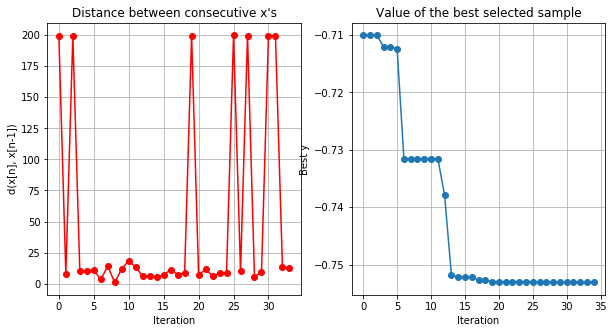

In [19]:
optimizer_3.plot_convergence()

In [8]:
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.8 )

In [24]:
eval_set = [(trainX,trainY), (testX, testY)]
evals_result = {}
eval_metric=["error", "logloss", "auc"]

gb = xgb.XGBClassifier(n_estimators=10000,
                       learning_rate=np.power(10, -0.28078499),
                       gamma=0,
                       max_depth=3,
                       min_child_weight = 1,
                       subsample = 1,
                       reg_alpha =10**(-9),                      
                       reg_lambda = 1,
                       objective="binary:logistic", tree_method="gpu_hist",predictor='gpu_predictor',
                       silent=False, verbose_eval=True, eval_metric=eval_metric, evals_result=evals_result)
gb

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None,
       eval_metric=['error', 'logloss', 'auc'], evals_result={}, gamma=0,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=0.5238597242511086, max_delta_step=None, max_depth=3,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=10000, n_jobs=None, num_parallel_tree=None,
       objective='binary:logistic', predictor='gpu_predictor',
       random_state=None, reg_alpha=1e-09, reg_lambda=1,
       scale_pos_weight=None, silent=False, subsample=1,
       tree_method='gpu_hist', validate_parameters=False,
       verbose_eval=True, verbosity=None)

In [11]:
%%time
gb.fit(trainX,trainY, eval_set=eval_set)

[0]	validation_0-error:0.14470	validation_0-logloss:0.48990	validation_0-auc:0.64514	validation_1-error:0.14496	validation_1-logloss:0.49007	validation_1-auc:0.64488
[1]	validation_0-error:0.14470	validation_0-logloss:0.42841	validation_0-auc:0.65382	validation_1-error:0.14496	validation_1-logloss:0.42872	validation_1-auc:0.65337
[2]	validation_0-error:0.14470	validation_0-logloss:0.40618	validation_0-auc:0.65606	validation_1-error:0.14496	validation_1-logloss:0.40658	validation_1-auc:0.65556
[3]	validation_0-error:0.14470	validation_0-logloss:0.39675	validation_0-auc:0.66409	validation_1-error:0.14496	validation_1-logloss:0.39722	validation_1-auc:0.66339
[4]	validation_0-error:0.14470	validation_0-logloss:0.39300	validation_0-auc:0.66710	validation_1-error:0.14496	validation_1-logloss:0.39349	validation_1-auc:0.66666
[5]	validation_0-error:0.14470	validation_0-logloss:0.39002	validation_0-auc:0.67607	validation_1-error:0.14496	validation_1-logloss:0.39054	validation_1-auc:0.67551
[6]	

[50]	validation_0-error:0.14470	validation_0-logloss:0.37785	validation_0-auc:0.70987	validation_1-error:0.14496	validation_1-logloss:0.37857	validation_1-auc:0.70890
[51]	validation_0-error:0.14470	validation_0-logloss:0.37774	validation_0-auc:0.71013	validation_1-error:0.14496	validation_1-logloss:0.37847	validation_1-auc:0.70915
[52]	validation_0-error:0.14470	validation_0-logloss:0.37757	validation_0-auc:0.71069	validation_1-error:0.14496	validation_1-logloss:0.37830	validation_1-auc:0.70968
[53]	validation_0-error:0.14470	validation_0-logloss:0.37749	validation_0-auc:0.71097	validation_1-error:0.14496	validation_1-logloss:0.37823	validation_1-auc:0.70992
[54]	validation_0-error:0.14470	validation_0-logloss:0.37744	validation_0-auc:0.71112	validation_1-error:0.14496	validation_1-logloss:0.37818	validation_1-auc:0.71008
[55]	validation_0-error:0.14470	validation_0-logloss:0.37741	validation_0-auc:0.71115	validation_1-error:0.14496	validation_1-logloss:0.37816	validation_1-auc:0.7100

[100]	validation_0-error:0.14461	validation_0-logloss:0.37341	validation_0-auc:0.72163	validation_1-error:0.14484	validation_1-logloss:0.37433	validation_1-auc:0.72019
[101]	validation_0-error:0.14461	validation_0-logloss:0.37338	validation_0-auc:0.72170	validation_1-error:0.14484	validation_1-logloss:0.37430	validation_1-auc:0.72026
[102]	validation_0-error:0.14460	validation_0-logloss:0.37333	validation_0-auc:0.72182	validation_1-error:0.14484	validation_1-logloss:0.37425	validation_1-auc:0.72037
[103]	validation_0-error:0.14459	validation_0-logloss:0.37316	validation_0-auc:0.72231	validation_1-error:0.14482	validation_1-logloss:0.37407	validation_1-auc:0.72086
[104]	validation_0-error:0.14457	validation_0-logloss:0.37309	validation_0-auc:0.72243	validation_1-error:0.14479	validation_1-logloss:0.37401	validation_1-auc:0.72100
[105]	validation_0-error:0.14456	validation_0-logloss:0.37303	validation_0-auc:0.72257	validation_1-error:0.14479	validation_1-logloss:0.37393	validation_1-auc:

[149]	validation_0-error:0.14377	validation_0-logloss:0.36900	validation_0-auc:0.73174	validation_1-error:0.14406	validation_1-logloss:0.36998	validation_1-auc:0.73023
[150]	validation_0-error:0.14378	validation_0-logloss:0.36882	validation_0-auc:0.73212	validation_1-error:0.14406	validation_1-logloss:0.36978	validation_1-auc:0.73067
[151]	validation_0-error:0.14379	validation_0-logloss:0.36880	validation_0-auc:0.73221	validation_1-error:0.14406	validation_1-logloss:0.36977	validation_1-auc:0.73073
[152]	validation_0-error:0.14379	validation_0-logloss:0.36878	validation_0-auc:0.73227	validation_1-error:0.14406	validation_1-logloss:0.36975	validation_1-auc:0.73077
[153]	validation_0-error:0.14380	validation_0-logloss:0.36853	validation_0-auc:0.73283	validation_1-error:0.14408	validation_1-logloss:0.36951	validation_1-auc:0.73130
[154]	validation_0-error:0.14378	validation_0-logloss:0.36852	validation_0-auc:0.73281	validation_1-error:0.14406	validation_1-logloss:0.36950	validation_1-auc:

[198]	validation_0-error:0.14325	validation_0-logloss:0.36584	validation_0-auc:0.73833	validation_1-error:0.14358	validation_1-logloss:0.36691	validation_1-auc:0.73666
[199]	validation_0-error:0.14322	validation_0-logloss:0.36581	validation_0-auc:0.73834	validation_1-error:0.14356	validation_1-logloss:0.36690	validation_1-auc:0.73667
[200]	validation_0-error:0.14319	validation_0-logloss:0.36579	validation_0-auc:0.73839	validation_1-error:0.14355	validation_1-logloss:0.36686	validation_1-auc:0.73673
[201]	validation_0-error:0.14318	validation_0-logloss:0.36577	validation_0-auc:0.73839	validation_1-error:0.14353	validation_1-logloss:0.36685	validation_1-auc:0.73674
[202]	validation_0-error:0.14317	validation_0-logloss:0.36576	validation_0-auc:0.73843	validation_1-error:0.14351	validation_1-logloss:0.36684	validation_1-auc:0.73678
[203]	validation_0-error:0.14317	validation_0-logloss:0.36567	validation_0-auc:0.73862	validation_1-error:0.14352	validation_1-logloss:0.36677	validation_1-auc:

[247]	validation_0-error:0.14208	validation_0-logloss:0.36360	validation_0-auc:0.74204	validation_1-error:0.14249	validation_1-logloss:0.36479	validation_1-auc:0.74024
[248]	validation_0-error:0.14204	validation_0-logloss:0.36356	validation_0-auc:0.74207	validation_1-error:0.14244	validation_1-logloss:0.36475	validation_1-auc:0.74028
[249]	validation_0-error:0.14197	validation_0-logloss:0.36343	validation_0-auc:0.74227	validation_1-error:0.14238	validation_1-logloss:0.36463	validation_1-auc:0.74047
[250]	validation_0-error:0.14198	validation_0-logloss:0.36339	validation_0-auc:0.74236	validation_1-error:0.14238	validation_1-logloss:0.36458	validation_1-auc:0.74057
[251]	validation_0-error:0.14196	validation_0-logloss:0.36337	validation_0-auc:0.74243	validation_1-error:0.14238	validation_1-logloss:0.36456	validation_1-auc:0.74063
[252]	validation_0-error:0.14194	validation_0-logloss:0.36334	validation_0-auc:0.74244	validation_1-error:0.14234	validation_1-logloss:0.36454	validation_1-auc:

[296]	validation_0-error:0.14134	validation_0-logloss:0.36137	validation_0-auc:0.74635	validation_1-error:0.14186	validation_1-logloss:0.36269	validation_1-auc:0.74439
[297]	validation_0-error:0.14134	validation_0-logloss:0.36136	validation_0-auc:0.74637	validation_1-error:0.14185	validation_1-logloss:0.36268	validation_1-auc:0.74442
[298]	validation_0-error:0.14133	validation_0-logloss:0.36131	validation_0-auc:0.74644	validation_1-error:0.14185	validation_1-logloss:0.36263	validation_1-auc:0.74448
[299]	validation_0-error:0.14133	validation_0-logloss:0.36130	validation_0-auc:0.74647	validation_1-error:0.14184	validation_1-logloss:0.36262	validation_1-auc:0.74451
[300]	validation_0-error:0.14132	validation_0-logloss:0.36129	validation_0-auc:0.74648	validation_1-error:0.14183	validation_1-logloss:0.36261	validation_1-auc:0.74452
[301]	validation_0-error:0.14133	validation_0-logloss:0.36128	validation_0-auc:0.74650	validation_1-error:0.14184	validation_1-logloss:0.36261	validation_1-auc:

[345]	validation_0-error:0.14058	validation_0-logloss:0.35995	validation_0-auc:0.74842	validation_1-error:0.14104	validation_1-logloss:0.36136	validation_1-auc:0.74639
[346]	validation_0-error:0.14050	validation_0-logloss:0.35988	validation_0-auc:0.74850	validation_1-error:0.14100	validation_1-logloss:0.36131	validation_1-auc:0.74646
[347]	validation_0-error:0.14050	validation_0-logloss:0.35985	validation_0-auc:0.74856	validation_1-error:0.14100	validation_1-logloss:0.36127	validation_1-auc:0.74652
[348]	validation_0-error:0.14050	validation_0-logloss:0.35981	validation_0-auc:0.74866	validation_1-error:0.14101	validation_1-logloss:0.36123	validation_1-auc:0.74664
[349]	validation_0-error:0.14050	validation_0-logloss:0.35980	validation_0-auc:0.74868	validation_1-error:0.14102	validation_1-logloss:0.36121	validation_1-auc:0.74665
[350]	validation_0-error:0.14047	validation_0-logloss:0.35979	validation_0-auc:0.74867	validation_1-error:0.14099	validation_1-logloss:0.36121	validation_1-auc:

[394]	validation_0-error:0.14009	validation_0-logloss:0.35883	validation_0-auc:0.75031	validation_1-error:0.14063	validation_1-logloss:0.36035	validation_1-auc:0.74809
[395]	validation_0-error:0.14009	validation_0-logloss:0.35882	validation_0-auc:0.75035	validation_1-error:0.14063	validation_1-logloss:0.36035	validation_1-auc:0.74811
[396]	validation_0-error:0.14009	validation_0-logloss:0.35879	validation_0-auc:0.75041	validation_1-error:0.14062	validation_1-logloss:0.36033	validation_1-auc:0.74816
[397]	validation_0-error:0.14008	validation_0-logloss:0.35879	validation_0-auc:0.75042	validation_1-error:0.14061	validation_1-logloss:0.36033	validation_1-auc:0.74817
[398]	validation_0-error:0.14008	validation_0-logloss:0.35877	validation_0-auc:0.75044	validation_1-error:0.14061	validation_1-logloss:0.36031	validation_1-auc:0.74820
[399]	validation_0-error:0.14007	validation_0-logloss:0.35876	validation_0-auc:0.75046	validation_1-error:0.14062	validation_1-logloss:0.36030	validation_1-auc:

[443]	validation_0-error:0.13978	validation_0-logloss:0.35804	validation_0-auc:0.75167	validation_1-error:0.14030	validation_1-logloss:0.35966	validation_1-auc:0.74927
[444]	validation_0-error:0.13977	validation_0-logloss:0.35803	validation_0-auc:0.75167	validation_1-error:0.14031	validation_1-logloss:0.35966	validation_1-auc:0.74927
[445]	validation_0-error:0.13977	validation_0-logloss:0.35802	validation_0-auc:0.75170	validation_1-error:0.14033	validation_1-logloss:0.35965	validation_1-auc:0.74929
[446]	validation_0-error:0.13978	validation_0-logloss:0.35801	validation_0-auc:0.75174	validation_1-error:0.14031	validation_1-logloss:0.35963	validation_1-auc:0.74932
[447]	validation_0-error:0.13977	validation_0-logloss:0.35799	validation_0-auc:0.75175	validation_1-error:0.14032	validation_1-logloss:0.35963	validation_1-auc:0.74933
[448]	validation_0-error:0.13977	validation_0-logloss:0.35799	validation_0-auc:0.75176	validation_1-error:0.14032	validation_1-logloss:0.35962	validation_1-auc:

[492]	validation_0-error:0.13938	validation_0-logloss:0.35732	validation_0-auc:0.75271	validation_1-error:0.13992	validation_1-logloss:0.35902	validation_1-auc:0.75019
[493]	validation_0-error:0.13935	validation_0-logloss:0.35731	validation_0-auc:0.75273	validation_1-error:0.13991	validation_1-logloss:0.35901	validation_1-auc:0.75021
[494]	validation_0-error:0.13935	validation_0-logloss:0.35730	validation_0-auc:0.75274	validation_1-error:0.13990	validation_1-logloss:0.35900	validation_1-auc:0.75022
[495]	validation_0-error:0.13933	validation_0-logloss:0.35729	validation_0-auc:0.75276	validation_1-error:0.13988	validation_1-logloss:0.35899	validation_1-auc:0.75023
[496]	validation_0-error:0.13933	validation_0-logloss:0.35728	validation_0-auc:0.75278	validation_1-error:0.13988	validation_1-logloss:0.35898	validation_1-auc:0.75025
[497]	validation_0-error:0.13931	validation_0-logloss:0.35723	validation_0-auc:0.75282	validation_1-error:0.13986	validation_1-logloss:0.35894	validation_1-auc:

[541]	validation_0-error:0.13903	validation_0-logloss:0.35663	validation_0-auc:0.75380	validation_1-error:0.13957	validation_1-logloss:0.35840	validation_1-auc:0.75119
[542]	validation_0-error:0.13902	validation_0-logloss:0.35662	validation_0-auc:0.75381	validation_1-error:0.13957	validation_1-logloss:0.35840	validation_1-auc:0.75120
[543]	validation_0-error:0.13903	validation_0-logloss:0.35662	validation_0-auc:0.75381	validation_1-error:0.13956	validation_1-logloss:0.35839	validation_1-auc:0.75120
[544]	validation_0-error:0.13901	validation_0-logloss:0.35659	validation_0-auc:0.75385	validation_1-error:0.13956	validation_1-logloss:0.35835	validation_1-auc:0.75123
[545]	validation_0-error:0.13900	validation_0-logloss:0.35658	validation_0-auc:0.75386	validation_1-error:0.13955	validation_1-logloss:0.35835	validation_1-auc:0.75124
[546]	validation_0-error:0.13900	validation_0-logloss:0.35657	validation_0-auc:0.75389	validation_1-error:0.13955	validation_1-logloss:0.35834	validation_1-auc:

[590]	validation_0-error:0.13874	validation_0-logloss:0.35617	validation_0-auc:0.75448	validation_1-error:0.13934	validation_1-logloss:0.35806	validation_1-auc:0.75162
[591]	validation_0-error:0.13874	validation_0-logloss:0.35616	validation_0-auc:0.75450	validation_1-error:0.13934	validation_1-logloss:0.35806	validation_1-auc:0.75163
[592]	validation_0-error:0.13874	validation_0-logloss:0.35615	validation_0-auc:0.75452	validation_1-error:0.13934	validation_1-logloss:0.35806	validation_1-auc:0.75163
[593]	validation_0-error:0.13874	validation_0-logloss:0.35613	validation_0-auc:0.75456	validation_1-error:0.13933	validation_1-logloss:0.35803	validation_1-auc:0.75169
[594]	validation_0-error:0.13872	validation_0-logloss:0.35612	validation_0-auc:0.75457	validation_1-error:0.13931	validation_1-logloss:0.35801	validation_1-auc:0.75169
[595]	validation_0-error:0.13870	validation_0-logloss:0.35611	validation_0-auc:0.75457	validation_1-error:0.13931	validation_1-logloss:0.35800	validation_1-auc:

[639]	validation_0-error:0.13845	validation_0-logloss:0.35573	validation_0-auc:0.75510	validation_1-error:0.13907	validation_1-logloss:0.35769	validation_1-auc:0.75213
[640]	validation_0-error:0.13844	validation_0-logloss:0.35572	validation_0-auc:0.75510	validation_1-error:0.13907	validation_1-logloss:0.35769	validation_1-auc:0.75213
[641]	validation_0-error:0.13844	validation_0-logloss:0.35572	validation_0-auc:0.75511	validation_1-error:0.13905	validation_1-logloss:0.35768	validation_1-auc:0.75214
[642]	validation_0-error:0.13844	validation_0-logloss:0.35571	validation_0-auc:0.75513	validation_1-error:0.13906	validation_1-logloss:0.35768	validation_1-auc:0.75216
[643]	validation_0-error:0.13843	validation_0-logloss:0.35569	validation_0-auc:0.75513	validation_1-error:0.13903	validation_1-logloss:0.35767	validation_1-auc:0.75216
[644]	validation_0-error:0.13843	validation_0-logloss:0.35569	validation_0-auc:0.75513	validation_1-error:0.13903	validation_1-logloss:0.35766	validation_1-auc:

[688]	validation_0-error:0.13826	validation_0-logloss:0.35537	validation_0-auc:0.75567	validation_1-error:0.13888	validation_1-logloss:0.35743	validation_1-auc:0.75254
[689]	validation_0-error:0.13826	validation_0-logloss:0.35536	validation_0-auc:0.75569	validation_1-error:0.13887	validation_1-logloss:0.35742	validation_1-auc:0.75256
[690]	validation_0-error:0.13826	validation_0-logloss:0.35535	validation_0-auc:0.75569	validation_1-error:0.13887	validation_1-logloss:0.35742	validation_1-auc:0.75256
[691]	validation_0-error:0.13826	validation_0-logloss:0.35535	validation_0-auc:0.75570	validation_1-error:0.13887	validation_1-logloss:0.35742	validation_1-auc:0.75256
[692]	validation_0-error:0.13826	validation_0-logloss:0.35535	validation_0-auc:0.75570	validation_1-error:0.13885	validation_1-logloss:0.35741	validation_1-auc:0.75256
[693]	validation_0-error:0.13825	validation_0-logloss:0.35534	validation_0-auc:0.75570	validation_1-error:0.13884	validation_1-logloss:0.35741	validation_1-auc:

[737]	validation_0-error:0.13801	validation_0-logloss:0.35497	validation_0-auc:0.75625	validation_1-error:0.13866	validation_1-logloss:0.35711	validation_1-auc:0.75301
[738]	validation_0-error:0.13801	validation_0-logloss:0.35496	validation_0-auc:0.75626	validation_1-error:0.13867	validation_1-logloss:0.35711	validation_1-auc:0.75301
[739]	validation_0-error:0.13801	validation_0-logloss:0.35496	validation_0-auc:0.75627	validation_1-error:0.13866	validation_1-logloss:0.35711	validation_1-auc:0.75301
[740]	validation_0-error:0.13800	validation_0-logloss:0.35495	validation_0-auc:0.75628	validation_1-error:0.13866	validation_1-logloss:0.35711	validation_1-auc:0.75302
[741]	validation_0-error:0.13801	validation_0-logloss:0.35495	validation_0-auc:0.75629	validation_1-error:0.13867	validation_1-logloss:0.35710	validation_1-auc:0.75303
[742]	validation_0-error:0.13801	validation_0-logloss:0.35495	validation_0-auc:0.75630	validation_1-error:0.13867	validation_1-logloss:0.35710	validation_1-auc:

[786]	validation_0-error:0.13786	validation_0-logloss:0.35463	validation_0-auc:0.75683	validation_1-error:0.13854	validation_1-logloss:0.35689	validation_1-auc:0.75338
[787]	validation_0-error:0.13786	validation_0-logloss:0.35463	validation_0-auc:0.75684	validation_1-error:0.13855	validation_1-logloss:0.35689	validation_1-auc:0.75338
[788]	validation_0-error:0.13785	validation_0-logloss:0.35462	validation_0-auc:0.75684	validation_1-error:0.13853	validation_1-logloss:0.35688	validation_1-auc:0.75338
[789]	validation_0-error:0.13785	validation_0-logloss:0.35462	validation_0-auc:0.75685	validation_1-error:0.13853	validation_1-logloss:0.35688	validation_1-auc:0.75338
[790]	validation_0-error:0.13785	validation_0-logloss:0.35461	validation_0-auc:0.75686	validation_1-error:0.13854	validation_1-logloss:0.35688	validation_1-auc:0.75339
[791]	validation_0-error:0.13785	validation_0-logloss:0.35460	validation_0-auc:0.75689	validation_1-error:0.13854	validation_1-logloss:0.35687	validation_1-auc:

[835]	validation_0-error:0.13773	validation_0-logloss:0.35434	validation_0-auc:0.75723	validation_1-error:0.13844	validation_1-logloss:0.35666	validation_1-auc:0.75367
[836]	validation_0-error:0.13773	validation_0-logloss:0.35434	validation_0-auc:0.75723	validation_1-error:0.13844	validation_1-logloss:0.35665	validation_1-auc:0.75367
[837]	validation_0-error:0.13773	validation_0-logloss:0.35433	validation_0-auc:0.75723	validation_1-error:0.13843	validation_1-logloss:0.35665	validation_1-auc:0.75367
[838]	validation_0-error:0.13773	validation_0-logloss:0.35433	validation_0-auc:0.75723	validation_1-error:0.13843	validation_1-logloss:0.35665	validation_1-auc:0.75366
[839]	validation_0-error:0.13773	validation_0-logloss:0.35433	validation_0-auc:0.75725	validation_1-error:0.13843	validation_1-logloss:0.35665	validation_1-auc:0.75367
[840]	validation_0-error:0.13772	validation_0-logloss:0.35432	validation_0-auc:0.75728	validation_1-error:0.13843	validation_1-logloss:0.35664	validation_1-auc:

[884]	validation_0-error:0.13757	validation_0-logloss:0.35398	validation_0-auc:0.75789	validation_1-error:0.13826	validation_1-logloss:0.35638	validation_1-auc:0.75420
[885]	validation_0-error:0.13756	validation_0-logloss:0.35398	validation_0-auc:0.75790	validation_1-error:0.13827	validation_1-logloss:0.35637	validation_1-auc:0.75421
[886]	validation_0-error:0.13755	validation_0-logloss:0.35397	validation_0-auc:0.75790	validation_1-error:0.13823	validation_1-logloss:0.35636	validation_1-auc:0.75421
[887]	validation_0-error:0.13754	validation_0-logloss:0.35397	validation_0-auc:0.75790	validation_1-error:0.13824	validation_1-logloss:0.35636	validation_1-auc:0.75421
[888]	validation_0-error:0.13753	validation_0-logloss:0.35396	validation_0-auc:0.75790	validation_1-error:0.13822	validation_1-logloss:0.35635	validation_1-auc:0.75422
[889]	validation_0-error:0.13753	validation_0-logloss:0.35396	validation_0-auc:0.75793	validation_1-error:0.13822	validation_1-logloss:0.35635	validation_1-auc:

[933]	validation_0-error:0.13745	validation_0-logloss:0.35370	validation_0-auc:0.75835	validation_1-error:0.13817	validation_1-logloss:0.35617	validation_1-auc:0.75455
[934]	validation_0-error:0.13745	validation_0-logloss:0.35370	validation_0-auc:0.75836	validation_1-error:0.13818	validation_1-logloss:0.35616	validation_1-auc:0.75456
[935]	validation_0-error:0.13745	validation_0-logloss:0.35369	validation_0-auc:0.75838	validation_1-error:0.13819	validation_1-logloss:0.35616	validation_1-auc:0.75458
[936]	validation_0-error:0.13745	validation_0-logloss:0.35369	validation_0-auc:0.75838	validation_1-error:0.13818	validation_1-logloss:0.35615	validation_1-auc:0.75459
[937]	validation_0-error:0.13744	validation_0-logloss:0.35369	validation_0-auc:0.75838	validation_1-error:0.13818	validation_1-logloss:0.35615	validation_1-auc:0.75458
[938]	validation_0-error:0.13744	validation_0-logloss:0.35368	validation_0-auc:0.75838	validation_1-error:0.13818	validation_1-logloss:0.35615	validation_1-auc:

[982]	validation_0-error:0.13734	validation_0-logloss:0.35345	validation_0-auc:0.75877	validation_1-error:0.13806	validation_1-logloss:0.35600	validation_1-auc:0.75482
[983]	validation_0-error:0.13733	validation_0-logloss:0.35345	validation_0-auc:0.75877	validation_1-error:0.13806	validation_1-logloss:0.35600	validation_1-auc:0.75481
[984]	validation_0-error:0.13733	validation_0-logloss:0.35344	validation_0-auc:0.75878	validation_1-error:0.13806	validation_1-logloss:0.35599	validation_1-auc:0.75482
[985]	validation_0-error:0.13733	validation_0-logloss:0.35344	validation_0-auc:0.75879	validation_1-error:0.13804	validation_1-logloss:0.35599	validation_1-auc:0.75482
[986]	validation_0-error:0.13731	validation_0-logloss:0.35343	validation_0-auc:0.75879	validation_1-error:0.13804	validation_1-logloss:0.35598	validation_1-auc:0.75482
[987]	validation_0-error:0.13731	validation_0-logloss:0.35343	validation_0-auc:0.75880	validation_1-error:0.13803	validation_1-logloss:0.35598	validation_1-auc:

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1,
       eval_metric=['error', 'logloss', 'auc'], evals_result={}, gamma=0,
       gpu_id=0, importance_type='gain', interaction_constraints=None,
       learning_rate=0.5238597242511086, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=1000, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', predictor='gpu_predictor',
       random_state=0, reg_alpha=1e-09, reg_lambda=1, scale_pos_weight=1,
       silent=False, subsample=1, tree_method='gpu_hist',
       validate_parameters=False, verbose_eval=True, verbosity=None)

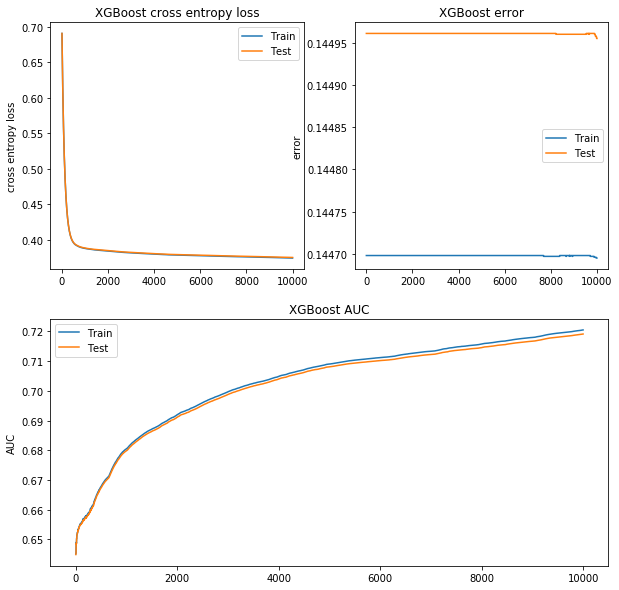

In [23]:
results = gb.evals_result()
epochs = len(results['validation_0']["error"])
x_axis = range(0, epochs)
# plot log loss
fig = plt.figure(figsize=(10,10))

gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0,0])
ax.plot(x_axis, results['validation_0']["logloss"], label='Train')
ax.plot(x_axis, results['validation_1']["logloss"], label='Test')

ax.legend()
plt.ylabel('cross entropy loss')
plt.title('XGBoost cross entropy loss')

ax = fig.add_subplot(gs[0,1])
ax.plot(x_axis, results['validation_0']["error"], label='Train')
ax.plot(x_axis, results['validation_1']["error"], label='Test')

ax.legend()
plt.ylabel('error')
plt.title('XGBoost error')

ax = fig.add_subplot(gs[1,:])
ax.plot(x_axis, results['validation_0']["auc"], label='Train')
ax.plot(x_axis, results['validation_1']["auc"], label='Test')

ax.legend()
plt.ylabel('AUC');
plt.title('XGBoost AUC');


In [20]:
optimizer_3.save_report("bayesian_report_with_regularization.txt")

In [24]:
optimizer_3.save_evaluations("evaluation3.txt")

In [17]:
optimizer_4 = BayesianOptimization(f=cv_score, 
                                 domain=search_space,
                                 model_type='GP_MCMC',
                                 acquisition_type ='EI_MCMC',
                                 acquisition_jitter = 0.1,
                                 exact_feval=True, 
                                 maximize=True,
                                 num_cores=2,
                                 verbosity=True, verbosity_model=True)


In [18]:
optimizer_4.run_optimization(max_iter=30, verbosity=True)

reconstraining parameters GP_regression.rbf
reconstraining parameters GP_regression.Gaussian_noise.variance


num acquisition: 1, time elapsed: 89.59s
num acquisition: 2, time elapsed: 187.66s
num acquisition: 3, time elapsed: 286.53s
num acquisition: 4, time elapsed: 438.91s
num acquisition: 5, time elapsed: 741.90s
num acquisition: 6, time elapsed: 853.10s
num acquisition: 7, time elapsed: 969.55s
num acquisition: 8, time elapsed: 1058.36s
num acquisition: 9, time elapsed: 1182.56s
num acquisition: 10, time elapsed: 1377.00s
num acquisition: 11, time elapsed: 1889.44s
num acquisition: 12, time elapsed: 1930.40s
num acquisition: 13, time elapsed: 2114.23s
num acquisition: 14, time elapsed: 2892.23s
num acquisition: 15, time elapsed: 3564.50s
num acquisition: 16, time elapsed: 3687.34s
num acquisition: 17, time elapsed: 3914.68s
num acquisition: 18, time elapsed: 4061.67s
num acquisition: 19, time elapsed: 4317.77s
num acquisition: 20, time elapsed: 4574.52s
num acquisition: 21, time elapsed: 4675.28s
num acquisition: 22, time elapsed: 4796.05s
num acquisition: 23, time elapsed: 5029.10s
num a

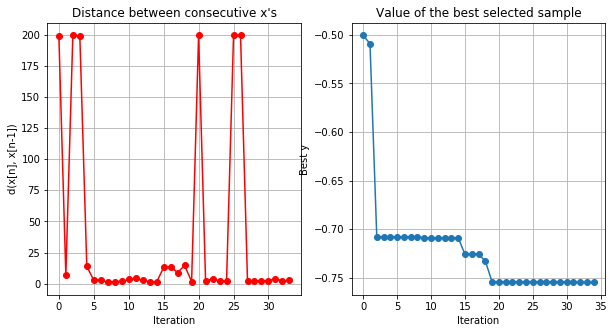

In [21]:
optimizer_4.plot_convergence()

In [22]:
optimizer_4.save_evaluations("evaluation4.txt")

In [23]:
optimizer_4.save_report("bayesian_report_MCMC.txt")